In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#clone Stylegan from GitHub.
!git clone https://github.com/NVlabs/stylegan.git

fatal: destination path 'stylegan' already exists and is not an empty directory.


In [ ]:
#Verify that Stylegan has been cloned.
!ls /content/stylegan/

config.py	     LICENSE.txt	    run_metrics.py
dataset_tool.py      metrics		    stylegan-teaser.png
dnnlib		     pretrained_example.py  training
generate_figures.py  README.md		    train.py


In [ ]:
# Select TensorFlow 1.x

%tensorflow_version 1.x

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
print(tf.__version__)

1.15.2


In [ ]:
# Add the Stylegan folder to Python so that you can import it.
import sys
sys.path.insert(0, "/content/stylegan")

import dnnlib
# Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
#
# This work is licensed under the Creative Commons Attribution-NonCommercial
# 4.0 International License. To view a copy of this license, visit
# http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
# Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

"""Minimal script for generating an image using pre-trained StyleGAN generator."""

import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
import pandas as pd
from tensorflow.keras import backend as K

In [ ]:
tflib.init_tf()

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D, \
    GlobalMaxPooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, \
    AveragePooling2D, Reshape, Permute, multiply
from keras_applications.imagenet_utils import _obtain_input_shape
# from tensorflow.keras.utils import layer_utils
from tensorflow.keras.utils import get_file
from tensorflow.keras import backend as K
# from keras_vggface import utils
# from keras.engine.topology import get_source_inputs
import warnings
from tensorflow.keras.models import Model
from tensorflow.keras import layers
V1_LABELS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v1.npy'
V2_LABELS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy'

VGG16_WEIGHTS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_vgg16.h5'
VGG16_WEIGHTS_PATH_NO_TOP = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5'


RESNET50_WEIGHTS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_resnet50.h5'
RESNET50_WEIGHTS_PATH_NO_TOP = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_resnet50.h5'

SENET50_WEIGHTS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_senet50.h5'
SENET50_WEIGHTS_PATH_NO_TOP = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_senet50.h5'


VGGFACE_DIR = 'models/vggface'




In [ ]:
def senet_se_block(input_tensor, stage, block, compress_rate=16, bias=False):
    conv1_down_name = 'conv' + str(stage) + "_" + str(
        block) + "_1x1_down"
    conv1_up_name = 'conv' + str(stage) + "_" + str(
        block) + "_1x1_up"

    num_channels = int(input_tensor.shape[-1])
    bottle_neck = int(num_channels // compress_rate)

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, num_channels))(se)
    se = Conv2D(bottle_neck, (1, 1), use_bias=bias,
                name=conv1_down_name)(se)
    se = Activation('relu')(se)
    se = Conv2D(num_channels, (1, 1), use_bias=bias,
                name=conv1_up_name)(se)
    se = Activation('sigmoid')(se)

    x = input_tensor
    x = multiply([x, se])
    return x


def senet_conv_block(input_tensor, kernel_size, filters,
                     stage, block, bias=False, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    bn_eps = 0.0001

    conv1_reduce_name = 'conv' + str(stage) + "_" + str(block) + "_1x1_reduce"
    conv1_increase_name = 'conv' + str(stage) + "_" + str(
        block) + "_1x1_increase"
    conv1_proj_name = 'conv' + str(stage) + "_" + str(block) + "_1x1_proj"
    conv3_name = 'conv' + str(stage) + "_" + str(block) + "_3x3"

    x = Conv2D(filters1, (1, 1), use_bias=bias, strides=strides,
               name=conv1_reduce_name)(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=conv1_reduce_name + "/bn",epsilon=bn_eps)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', use_bias=bias,
               name=conv3_name)(x)
    x = BatchNormalization(axis=bn_axis, name=conv3_name + "/bn",epsilon=bn_eps)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv1_increase_name, use_bias=bias)(x)
    x = BatchNormalization(axis=bn_axis, name=conv1_increase_name + "/bn" ,epsilon=bn_eps)(x)

    se = senet_se_block(x, stage=stage, block=block, bias=True)

    shortcut = Conv2D(filters3, (1, 1), use_bias=bias, strides=strides,
                      name=conv1_proj_name)(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis,
                                  name=conv1_proj_name + "/bn",epsilon=bn_eps)(shortcut)

    m = layers.add([se, shortcut])
    m = Activation('relu')(m)
    return m


def senet_identity_block(input_tensor, kernel_size,
                         filters, stage, block, bias=False):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    bn_eps = 0.0001

    conv1_reduce_name = 'conv' + str(stage) + "_" + str(block) + "_1x1_reduce"
    conv1_increase_name = 'conv' + str(stage) + "_" + str(
        block) + "_1x1_increase"
    conv3_name = 'conv' + str(stage) + "_" + str(block) + "_3x3"

    x = Conv2D(filters1, (1, 1), use_bias=bias,
               name=conv1_reduce_name)(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=conv1_reduce_name + "/bn",epsilon=bn_eps)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', use_bias=bias,
               name=conv3_name)(x)
    x = BatchNormalization(axis=bn_axis, name=conv3_name + "/bn",epsilon=bn_eps)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv1_increase_name, use_bias=bias)(x)
    x = BatchNormalization(axis=bn_axis, name=conv1_increase_name + "/bn",epsilon=bn_eps)(x)

    se = senet_se_block(x, stage=stage, block=block, bias=True)

    m = layers.add([se, input_tensor])
    m = Activation('relu')(m)

    return m


def SENET50(include_top=True, weights='vggface',
            input_tensor=None, input_shape=None,
            pooling=None,
            classes=8631):
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    bn_eps = 0.0001

    x = Conv2D(
        64, (7, 7), use_bias=False, strides=(2, 2), padding='same',
        name='conv1/7x7_s2')(img_input)
    x = BatchNormalization(axis=bn_axis, name='conv1/7x7_s2/bn',epsilon=bn_eps)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = senet_conv_block(x, 3, [64, 64, 256], stage=2, block=1, strides=(1, 1))
    x = senet_identity_block(x, 3, [64, 64, 256], stage=2, block=2)
    x = senet_identity_block(x, 3, [64, 64, 256], stage=2, block=3)

    x = senet_conv_block(x, 3, [128, 128, 512], stage=3, block=1)
    x = senet_identity_block(x, 3, [128, 128, 512], stage=3, block=2)
    x = senet_identity_block(x, 3, [128, 128, 512], stage=3, block=3)
    x = senet_identity_block(x, 3, [128, 128, 512], stage=3, block=4)

    x = senet_conv_block(x, 3, [256, 256, 1024], stage=4, block=1)
    x = senet_identity_block(x, 3, [256, 256, 1024], stage=4, block=2)
    x = senet_identity_block(x, 3, [256, 256, 1024], stage=4, block=3)
    x = senet_identity_block(x, 3, [256, 256, 1024], stage=4, block=4)
    x = senet_identity_block(x, 3, [256, 256, 1024], stage=4, block=5)
    x = senet_identity_block(x, 3, [256, 256, 1024], stage=4, block=6)

    x = senet_conv_block(x, 3, [512, 512, 2048], stage=5, block=1)
    x = senet_identity_block(x, 3, [512, 512, 2048], stage=5, block=2)
    x = senet_identity_block(x, 3, [512, 512, 2048], stage=5, block=3)

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='classifier')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vggface_senet50')

    # load weights
    if weights == 'vggface':
        if include_top:
            weights_path = get_file('rcmalli_vggface_tf_senet50.h5',
                                    SENET50_WEIGHTS_PATH,
                                    cache_subdir=VGGFACE_DIR)
        else:
            weights_path = get_file('rcmalli_vggface_tf_notop_senet50.h5',
                                    SENET50_WEIGHTS_PATH_NO_TOP,
                                    cache_subdir=VGGFACE_DIR)
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)
            if include_top:
                maxpool = model.get_layer(name='avg_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='classifier')
                layer_utils.convert_dense_weights_data_format(dense, shape,
                                                              'channels_first')

        if K.image_data_format() == 'channels_first' and K.backend() == 'tensorflow':
            warnings.warn('You are using the TensorFlow backend, yet you '
                          'are using the Theano '
                          'image data format convention '
                          '(`image_data_format="channels_first"`). '
                          'For best performance, set '
                          '`image_data_format="channels_last"` in '
                          'your Keras config '
                          'at ~/.keras/keras.json.')
    elif weights is not None:
        model.load_weights(weights)

    return model


In [ ]:
def VGGFace(include_top=True, model='vgg16', weights='vggface',
            input_tensor=None, input_shape=None,
            pooling=None,
            classes=None):
    """Instantiates the VGGFace architectures.
    Optionally loads weights pre-trained
    on VGGFace datasets. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "vggface" (pre-training on VGGFACE datasets).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        model: selects the one of the available architectures 
            vgg16, resnet50 or senet50 default is vgg16.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """

    if weights not in {'vggface', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `vggface`'
                         '(pre-training on VGGFace Datasets).')

    if model == 'vgg16':

        if classes is None:
            classes = 2622

        if weights == 'vggface' and include_top and classes != 2622:
            raise ValueError(
                'If using `weights` as vggface original with `include_top`'
                ' as true, `classes` should be 2622')

        return VGG16(include_top=include_top, input_tensor=input_tensor,
                     input_shape=input_shape, pooling=pooling,
                     weights=weights,
                     classes=classes)


    if model == 'resnet50':

        if classes is None:
            classes = 8631

        if weights == 'vggface' and include_top and classes != 8631:
            raise ValueError(
                'If using `weights` as vggface original with `include_top`'
                ' as true, `classes` should be 8631')

        return RESNET50(include_top=include_top, input_tensor=input_tensor,
                        input_shape=input_shape, pooling=pooling,
                        weights=weights,
                        classes=classes)

    if model == 'senet50':

        if classes is None:
            classes = 8631

        if weights == 'vggface' and include_top and classes != 8631:
            raise ValueError(
                'If using `weights` as vggface original with `include_top`'
                ' as true, `classes` should be 8631')

        return SENET50(include_top=include_top, input_tensor=input_tensor,
                        input_shape=input_shape, pooling=pooling,
                        weights=weights,
                        classes=classes)

In [ ]:
vgg_features = VGGFace(include_top=False, model="senet50", input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max
layers = tf.keras.layers

#custom parameters
nb_class = 5
last_layer = vgg_features.get_layer('global_average_pooling2d_16').output
x = layers.Dense(128, activation="relu")(last_layer)
x = layers.Dropout(0.25)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.25)(x)
out = layers.Dense(nb_class, activation='softmax', name='classifier')(x)
vggface_model = Model(inputs=vgg_features.input, outputs=out)



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
104947712/104944616 [==============================] - 2s 0us/step


In [ ]:
vggface_model.load_weights("/content/drive/My Drive/Research-Dataset/UTKface-dlib-cropped-faces/saved_best_models/checkpoint.h5")

In [ ]:
n = 1000
path = "/content/drive/My Drive/Genrated_datasets/RealTimeRaceClassifier-Generated_Images"
path_2 = "/content/drive/My Drive/Genrated_datasets/RealTimeRaceClassifier-Generated_Images_Info.csv"


if not os.path.exists(path):
  os.makedirs(path)
# Initialize TensorFlow.

In [ ]:
url = 'https://drive.google.com/uc?id=19B-1B7MJq5_ezo_5qibUrYhV1RyhKIwh' # karras2019stylegan-ffhq-1024x1024.pkl
with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
    _G, _D, Gs = pickle.load(f)
    # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
    # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
    # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Print network details.
Gs.print_layers()

# Pick latent vector.
rnd = np.random.RandomState()




Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/latents_in            -         (?, 512)             -               
G_mapping/labels_in             -         (?, 0)               -               
G_mapping/PixelNorm             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656 

In [ ]:
def preprocess_input(x, data_format=None, version=1):
    x_temp = np.copy(x)
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}

    if version == 1:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 93.5940
            x_temp[:, 1, :, :] -= 104.7624
            x_temp[:, 2, :, :] -= 129.1863
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 93.5940
            x_temp[..., 1] -= 104.7624
            x_temp[..., 2] -= 129.1863

    elif version == 2:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 91.4953
            x_temp[:, 1, :, :] -= 103.8827
            x_temp[:, 2, :, :] -= 131.0912
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 91.4953
            x_temp[..., 1] -= 103.8827
            x_temp[..., 2] -= 131.0912
    else:
        raise NotImplementedError

    return x_temp

In [ ]:
filename=  "/content/drive/My Drive/sample-generated-images/Asian/Image_635.png"


In [ ]:
image = PIL.Image.open(filename)
image = image.resize((224,224))
img = np.array(image).astype(np.float32)
img = np.expand_dims(img, axis=0)
img_n = preprocess_input(img)
img_n.shape

(1, 224, 224, 3)

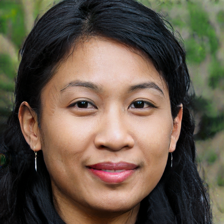

In [ ]:
image

In [ ]:
lr = 1e-4
vggface_model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
              loss="categorical_crossentropy", #loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
vggface_model.predict(img_n)

array([[0.8871282 , 0.00412859, 0.04267942, 0.05961733, 0.00644649]],
      dtype=float32)

In [ ]:
print(np.argmax(vggface_model.predict(img_n)))

0


In [ ]:
inidces_to_class = {0: 'Asian', 1: 'Black', 2: 'Indian', 3: 'Others', 4: 'White'}
class_to_index = {value:key for key, value in inidces_to_class.items()}

In [ ]:
 # Generate image.

 def generate_images(current_race_index, num_images = 10, threshold=0.7):
  
  images = []
  latent_inputs =[]
  while len(images) < num_images:
    latents = rnd.randn(1, Gs.input_shape[1])



    
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    gen_images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)
    img = gen_images[0]
    img = PIL.Image.fromarray(img)
    img = img.resize((224, 224))
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    pred = vggface_model.predict(img)[0]
    pred_class = np.argmax(pred) 
    if pred[pred_class] >= threshold and pred_class == current_race_index:
      images.append(gen_images[0])
      latent_inputs.append(latents)

  return images, latent_inputs

In [ ]:
import matplotlib.pyplot as plt
# ploat an image
def plot_image(image_arr, title):
    fig,axes = plt.subplots(2,5,figsize=(20,20))
    axes = axes.flatten()
    for img,ax in zip(image_arr,axes):
        img = PIL.Image.fromarray(img)
        img = img.resize((224, 224))
        ax.imshow(img)
        plt.tight_layout()
        ax.set_title(title)
    plt.show()

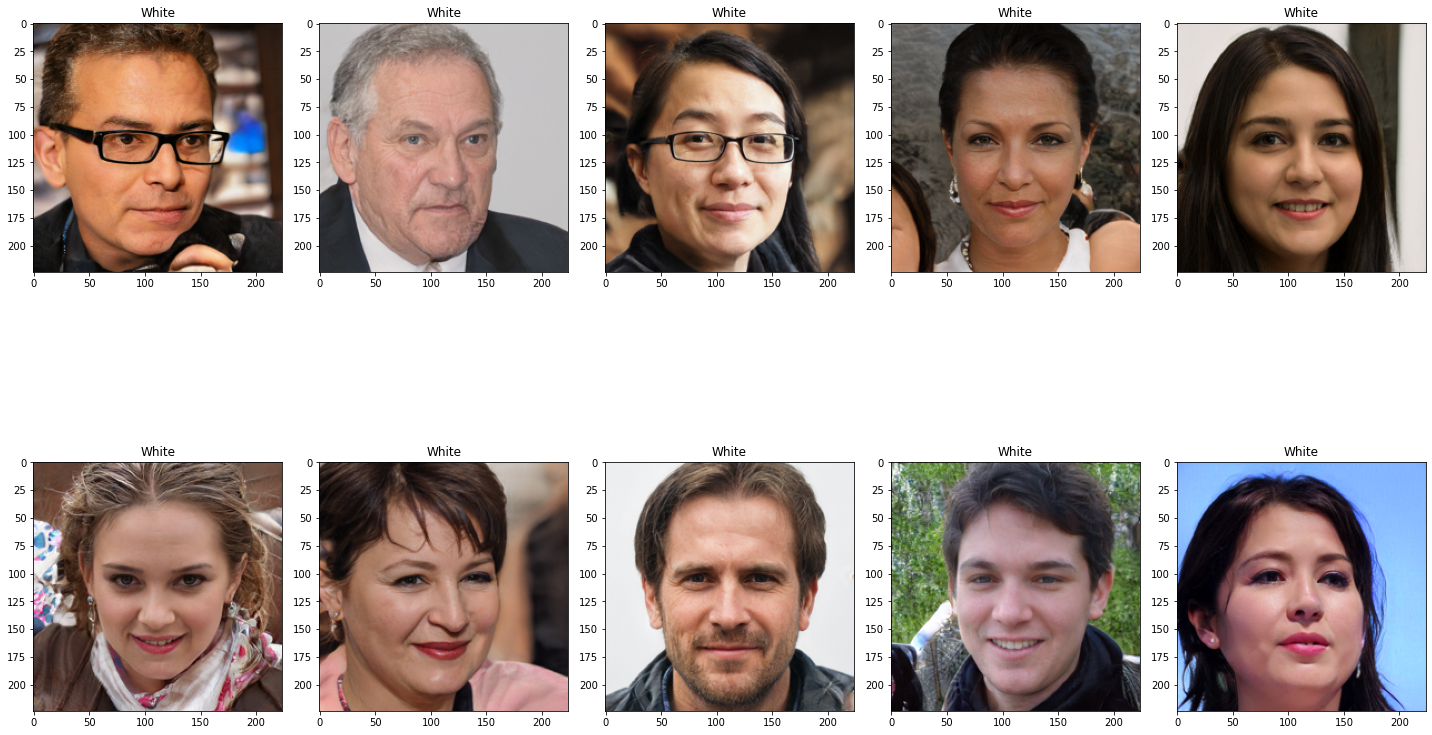

In [ ]:
# !rm -rf /content/drive/My\ Drive/datasets
white_images, white_latents = generate_images(class_to_index["White"], num_images = 10)
plot_image(white_images, "White")

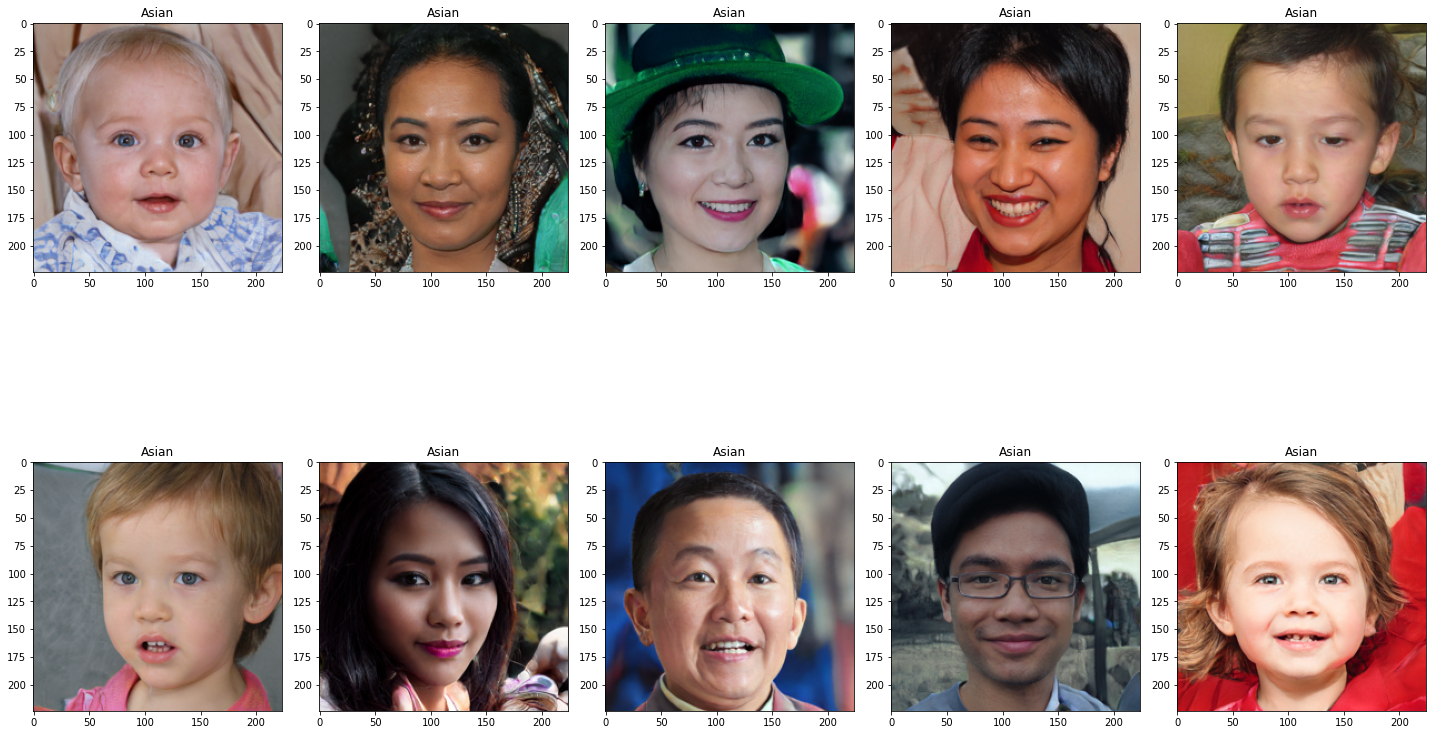

In [ ]:
asian_images, asian_latents = generate_images(class_to_index["Asian"], num_images = 10)
plot_image(asian_images, "Asian")

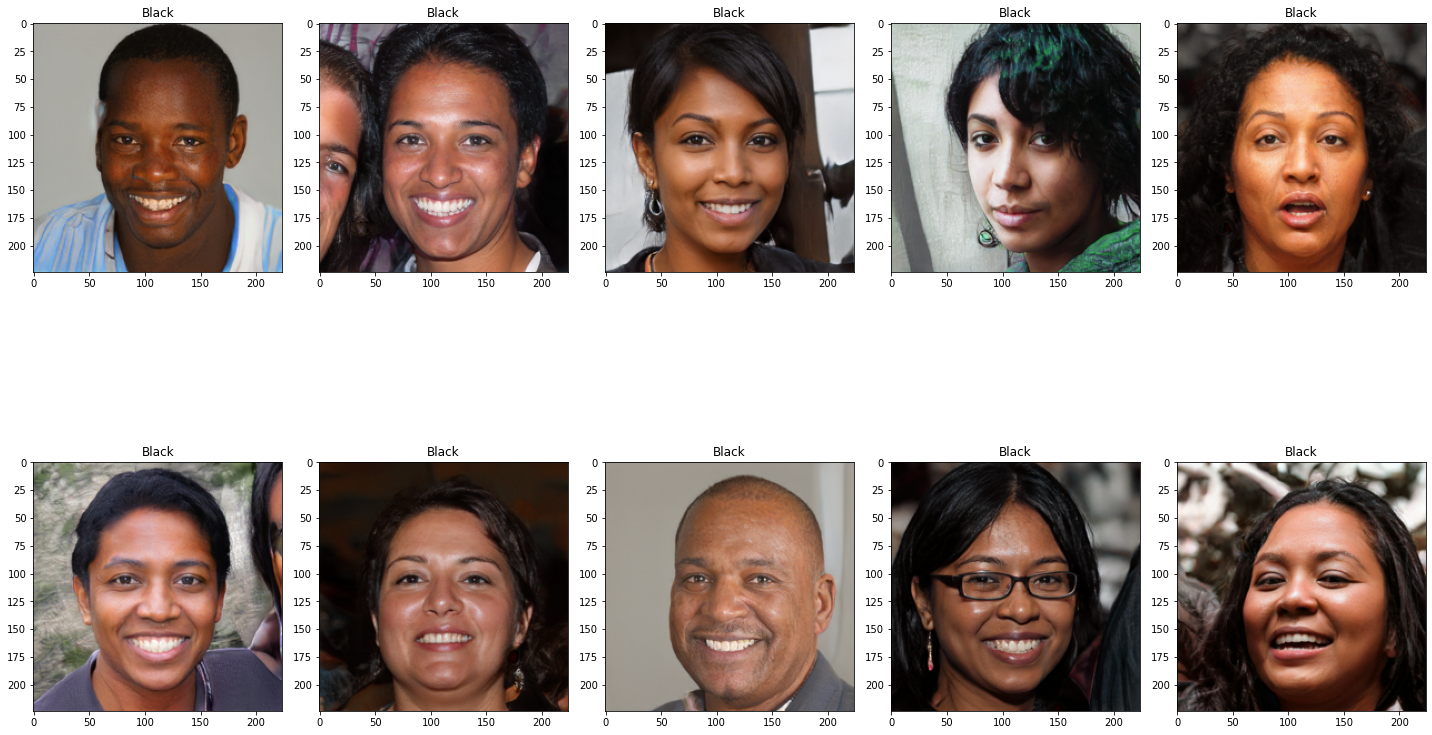

In [ ]:
black_images, black_latents = generate_images(class_to_index["Black"], num_images = 10)
plot_image(black_images, "Black")

In [ ]:
# Image_data = pd.read_csv("/content/drive/My Drive/Genrated_datasets/Generated_Images_Info.csv")
# Image_data.head()

In [ ]:
class_to_index.keys()

dict_keys(['Asian', 'Black', 'Indian', 'Others', 'White'])

In [ ]:
output_folder = "/content/drive/My Drive/Genrated_datasets/Generated_Images-realtime"
csv_path = "/content/drive/My Drive/Genrated_datasets/Generated_Images-realtime/Generated_Images_Info.csv"

In [ ]:
if not os.path.exists(output_folder):
  os.mkdir(output_folder)
else:
  print("the path exist")

the path exist


In [ ]:
for class_ in class_to_index:
  if not os.path.exists(os.path.join(output_folder, class_)):
    os.mkdir(os.path.join(output_folder, class_))

In [ ]:
num_images_to_generate_per_class = 2000
images_per_iter = 2

In [ ]:
def save_images(images, labels,  current_image_index):
  image_filenames = []
  for i in range(len(images)):
    image = images[i]
    image = PIL.Image.fromarray(image)
    output_path = os.path.join(output_folder, labels[i], "image-{}.png".format(current_image_index))
    image_filenames.append(output_path)
    image.save(output_path)
    current_image_index += 1
  return image_filenames, current_image_index

In [ ]:
if os.path.exists(csv_path):
    latent_df = pd.read_csv(csv_path)
else:
    latent_df = None
    
 



In [ ]:

current_image_index = 0

In [ ]:


for i in range(num_images_to_generate_per_class//images_per_iter):
  if latent_df is not None:
    current_image_index = len(latent_df)
  
  for class_, class_index  in class_to_index.items():
    if class_ == "Others":
      continue
    images, latents_inputs = generate_images(class_index, num_images = images_per_iter)
    image_labels = [class_ for i in range(len(images))]
    file_paths, current_image_index =  save_images(images,image_labels,  current_image_index)
    
    latents_inputs = np.concatenate(latents_inputs, axis=0)
    filename_df = pd.DataFrame(dict(filename = file_paths, labels=image_labels))
    lat_df  = pd.DataFrame(data = latents_inputs)
    whole_df = pd.concat([filename_df, lat_df], axis=1)
    
    if latent_df is None:
      latent_df = whole_df
    else:
      whole_df.columns = latent_df.columns
      latent_df = latent_df.append(whole_df)
    latent_df.to_csv(csv_path, index=False)
  


OSError: ignored

In [ ]:
df1 = pd.DataFrame(dict(i = np.arange(10), b = np.random.randn(10)))
df2 = pd.DataFrame(data = np.random.randn(10, 3))

In [ ]:
df = pd.concat([df1, df2], axis=1)

In [ ]:
df.head()

i         b         0         1         2
0  0 -0.294250 -1.313731  0.457598 -1.752718
1  1 -0.833275 -0.174994 -0.330216  0.335580
2  2  1.027536  1.078405 -1.072490  0.963573
3  3  0.386243  0.290414  0.536236 -0.933415
4  4 -0.617319  0.285451  0.121188  0.363894

In [ ]:
df1 = pd.DataFrame(dict(i = np.arange(10), b = np.random.randn(10)))
df2 = pd.DataFrame(data = np.random.randn(10, 3))
df3 = pd.concat([df1, df2], axis=1)

In [ ]:
df.head()

In [ ]:
df3.head()

In [ ]:
new_df = pd.concat([df, df3], axis=0, ignore_index=True)

In [ ]:
# new_df = new_df.reset_index()
new_df.head(20)

i         b         0         1         2
0  0  0.548306 -0.528987  0.158496 -0.224885
1  1 -0.705897 -1.472730 -1.513799  0.135186
2  2 -0.713855  1.668560 -0.171961  0.612246
3  3 -0.114773 -1.320782 -2.118086  1.365713
4  4  0.443043  0.387495 -1.239311 -0.691662
5  5  0.443631 -0.084390  0.131568  0.174288
6  6 -1.919769  0.332209 -0.374561  1.419566
7  7 -0.453592 -0.688971 -0.104083 -0.865552
8  8  1.003794 -0.095526  0.435319  0.175184
9  9 -1.017856 -1.793739 -0.683878 -0.103090
0  0  0.010128 -0.080633  0.497596  0.070348
1  1  1.814006  2.022239 -1.510540 -1.013625
2  2  0.226943  2.079202 -0.063574 -0.638300
3  3 -0.304104  1.039172  0.726601  0.263816
4  4  0.620071  1.533679  0.255796 -1.596120
5  5 -0.800204  0.524590 -0.025897 -0.201008
6  6  0.741898 -0.039937  0.327665 -0.430576
7  7  0.855849  0.272266  0.477111 -2.118016
8  8 -0.864017 -0.941630  1.804130 -1.071122
9  9  0.718987  0.055995 -2.605423 -0.777464

## Iterative generative

In [ ]:
output_folder

'/content/drive/My Drive/Genrated_datasets/Generated_Images-realtime'

In [ ]:
ls "/content/drive/My Drive/Genrated_datasets/Generated_Images-realtime"

Asian/  Black/  Generated_Images_Info.csv  Indian/  Others/  White/


In [ ]:
len("/content/drive/My Drive/Genrated_datasets/Generated_Images-realtime/Asian")

73